In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34, resnet50
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
import time
import pickle
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from medmnist import PathMNIST

from eqCLR.eq_resnet import EqResNet18, Mixed_EqResnet18
from eqCLR.test_resnet import Wide_ResNet
from evaluation import model_eval, dataset_to_X_y, lin_eval_rep
from escnn.nn import GeometricTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-12-05 14:43:03.266921: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 14:43:12.972018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 14:43:50.368774: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data and models

In [3]:
###################### PARAMS ##############################

BACKBONE = "resnet18"

BATCH_SIZE = 512
N_EPOCHS = 100 # 1000
N_CPU_WORKERS = 16
BASE_LR = 0.03         # important
WEIGHT_DECAY = 5e-4    # important
MOMENTUM = 0.9
PROJECTOR_HIDDEN_SIZE = 1024
PROJECTOR_OUTPUT_SIZE = 128
CROP_LOW_SCALE = 0.2
GRAYSCALE_PROB = 0.1   # important
PRINT_EVERY_EPOCHS = 1

In [4]:
###################### DATA LOADER #########################

pmnist_train = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())
pmnist_test = PathMNIST(split='test', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())

print("Data loaded.")

# additional rotation
class RandomRightAngleRotation:
    """Randomly rotate PIL image by 90, 180, or 270 degrees."""
    def __call__(self, x):
        angle = int(torch.randint(1, 4, ()).item()) * 90
        return x.rotate(angle)

transforms_ssl = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32, scale=(CROP_LOW_SCALE, 1)),
        # RandomRightAngleRotation(), # additional rotation
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply(
            [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
        ),
        transforms.RandomGrayscale(p=GRAYSCALE_PROB),
        transforms.ToTensor(), # NB: runtime faster when this line is last
    ]
)

class PairedTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return (self.transform(x), self.transform(x))


paired_ssl_transforms = PairedTransform(transforms_ssl)

pmnist_train_ssl = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=paired_ssl_transforms)

pmnist_loader_ssl = DataLoader(
    pmnist_train_ssl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU_WORKERS,
    pin_memory=True,
)

Data loaded.


In [5]:
class ResNetwithProjector(nn.Module):
    def __init__(self, backbone_network, no_downsampling=False):
        super().__init__()

        self.backbone = backbone_network(weights=None)
        self.backbone_output_dim = self.backbone.fc.in_features

        if no_downsampling:
            self.backbone.conv1 = nn.Conv2d(
                3, 64, kernel_size=3, stride=1, padding=1, bias=False
            )
            self.backbone.maxpool = nn.Identity()
            
        self.backbone.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(self.backbone_output_dim, PROJECTOR_HIDDEN_SIZE), 
            nn.ReLU(), 
            nn.Linear(PROJECTOR_HIDDEN_SIZE, PROJECTOR_OUTPUT_SIZE),
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        return h, z
    
backbones = {
   "resnet18": resnet18,    # backbone_output_dim = 512
   "resnet34": resnet34,    # backbone_output_dim = 512
   "resnet50": resnet50,    # backbone_output_dim = 2048
}

In [9]:
# trained with rotations, conv1 having stride=2, with maxpooling
model_resnet18 = ResNetwithProjector(backbones[BACKBONE]).to(device)
model_resnet18.load_state_dict(torch.load('results/model_weights/7117-path_mnist-resnet18_conv1s2_w_maxpool_w_rotation_weights.pt', weights_only=True))

<All keys matched successfully>

In [5]:
# default resnet architecture N=4
model_eq = EqResNet18(N=4).to(device)
model_eq.load_state_dict(torch.load('results/model_weights/3957-path_mnist-eqCLR_resnet18_wo_rotation.pt', weights_only=True))

<All keys matched successfully>

In [3]:
# default resnet architecture N=8
model_eq_n8 = EqResNet18(N=8).to(device)
model_eq_n8.load_state_dict(torch.load('results/model_weights/9521-path_mnist-eqCLR_resnet18_wo_rot_N8_weights.pt', weights_only=True))

<All keys matched successfully>

# Orientation test

In [ ]:
H = W = 10
grid_y, grid_x = torch.meshgrid(
    torch.linspace(-1, 1, H, device=device),
    torch.linspace(-1, 1, W, device=device),
    indexing="ij"
)

img = (grid_x.abs() < 0.03).float()
x = img.unsqueeze(0).repeat(1, 10, 1, 1)

plt.imshow(x[0, 0].cpu(), cmap='gray')
plt.colorbar()
plt.show()

In [11]:
import torch
import numpy as np
from escnn.nn import GeometricTensor
from escnn.nn import EquivariantModule

def get_module_device(module):
    # Check parameters
    for p in module.parameters():
        return p.device
    # Check buffers (ESCNN layers often store filters as buffers)
    for b in module.buffers():
        return b.device
    return torch.device("cpu")

In [35]:
def check_transformation(self, x='line'):
    device = get_module_device(self)

    c = self.in_type.size
    H = W = 4  # or 10, like your example

    # create an empty image
    if x == 'line':
        img = torch.zeros(H, W, device=device)

        # draw a vertical line in the middle
        img[:, W // 2] = 1.0

        # repeat this structured image for all c channels
        # final shape: (1, c, H, W)
        x_tensor = img.unsqueeze(0).repeat(c, 1, 1)      
        x_tensor = x_tensor.unsqueeze(0)
    elif x == 'random':
        x_tensor = torch.randn(1, c, H, W, device=device)
    x = GeometricTensor(x_tensor, self.in_type)

    fig, ax = plt.subplots(2, 5, figsize=(15, 5))

    ax[0, 0].imshow(x_tensor[0, 0].detach().cpu(), cmap='gray')
    ax[0, 0].set_title("x")

    ax[1, 0].axis('off')

    # apply layer
    group_elements = self.in_type.gspace.fibergroup.elements
    testing_elements = [g for g in group_elements if np.isclose(g.to('radians') % (np.pi/2), 0)]
    
    errors = []
    for i, el in enumerate(testing_elements):
        # Forward + transform
        out1 = self(x).transform(el).tensor.detach().cpu().numpy()
        out2 = self(x.transform(el)).tensor.detach().cpu().numpy()
        print(out1.shape, out2.shape)

        errors.append(np.abs(out1 - out2).reshape(-1))

        # Plot
        ax[0, i+1].imshow(out1[0, 0], cmap='gray')
        ax[0, i+1].set_title(f"{el}f(x)")

        ax[1, i+1].imshow(out2[0, 0], cmap='gray')
        ax[1, i+1].set_title(f"f({el}x)")

    errors = np.array(errors)
    errors_mean = np.mean(errors)
    ax[1, 0].text(0.5, 0.5, f'Equivariant error:\n{errors_mean:.2e}', ha='center', va='center', fontsize=12)
    
    for ax in ax.flatten():
        ax.axis('off')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False) 


(1, 256, 2, 2) (1, 256, 2, 2)
(1, 256, 2, 2) (1, 256, 2, 2)
(1, 256, 2, 2) (1, 256, 2, 2)
(1, 256, 2, 2) (1, 256, 2, 2)


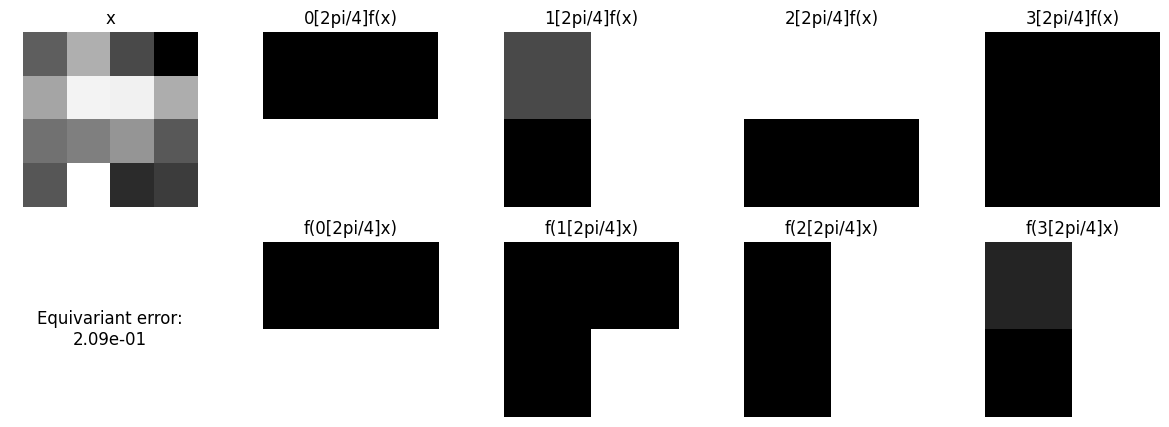

In [36]:
check_transformation(model_eq.maxpool, x='random')

In [61]:
def check_transformation2(self, x='random'):
    device = get_module_device(self)

    c = self.in_type.size
    H = W = 4  # or 10, like your example

    # create an empty image
    if x == 'line':
        img = torch.zeros(H, W, device=device)

        # draw a vertical line in the middle
        img[:, W // 2] = 1.0

        # repeat this structured image for all c channels
        # final shape: (1, c, H, W)
        x_tensor = img.unsqueeze(0).repeat(c, 1, 1)      
        x_tensor = x_tensor.unsqueeze(0)
    elif x == 'random':
        x_tensor = torch.randn(1, c, H, W, device=device)
    x = GeometricTensor(x_tensor, self.in_type)

    fig, ax = plt.subplots(4, 4, figsize=(12, 8))

    # plot x
    x_plot = x.tensor.detach().cpu().numpy()
    ax[0, 0].imshow(x_plot[0, 0], cmap='gray')
    ax[0, 0].set_title("x")

    # f(x)
    f_x = self(x).tensor.detach().cpu().numpy()
    ax[1, 0].imshow(f_x[0, 0], cmap='gray')
    ax[1, 0].set_title("f(x)")

    ax[1, 0].axis('off')
    ax[2, 0].axis('off')
    ax[3, 0].axis('off')

    # apply layer
    group_elements = self.in_type.gspace.fibergroup.elements
    testing_elements = [g for g in group_elements if np.isclose(g.to('radians') % (np.pi/2), 0)]
    
    for i, el in enumerate(testing_elements):
        # Forward + transform
        out1 = self(x).transform(el).tensor.detach().cpu().numpy()
        out2 = self(x.transform(el)).tensor.detach().cpu().numpy()

        error = np.abs(out1 - out2).reshape(-1)

        ax[i, 1].imshow(out1[0, 0], cmap='gray')
        ax[i, 1].set_title(f"{el}f(x)")

        ax[i, 2].imshow(out2[0, 0], cmap='gray')
        ax[i, 2].set_title(f"f({el}x)")

        ax[i, 3].text(0.5, 0.5, f'Equivariant error:\n{error.mean():.2e}', ha='center', va='center', fontsize=12)

    for ax in ax.flatten():
        ax.axis('off')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    plt.tight_layout() 


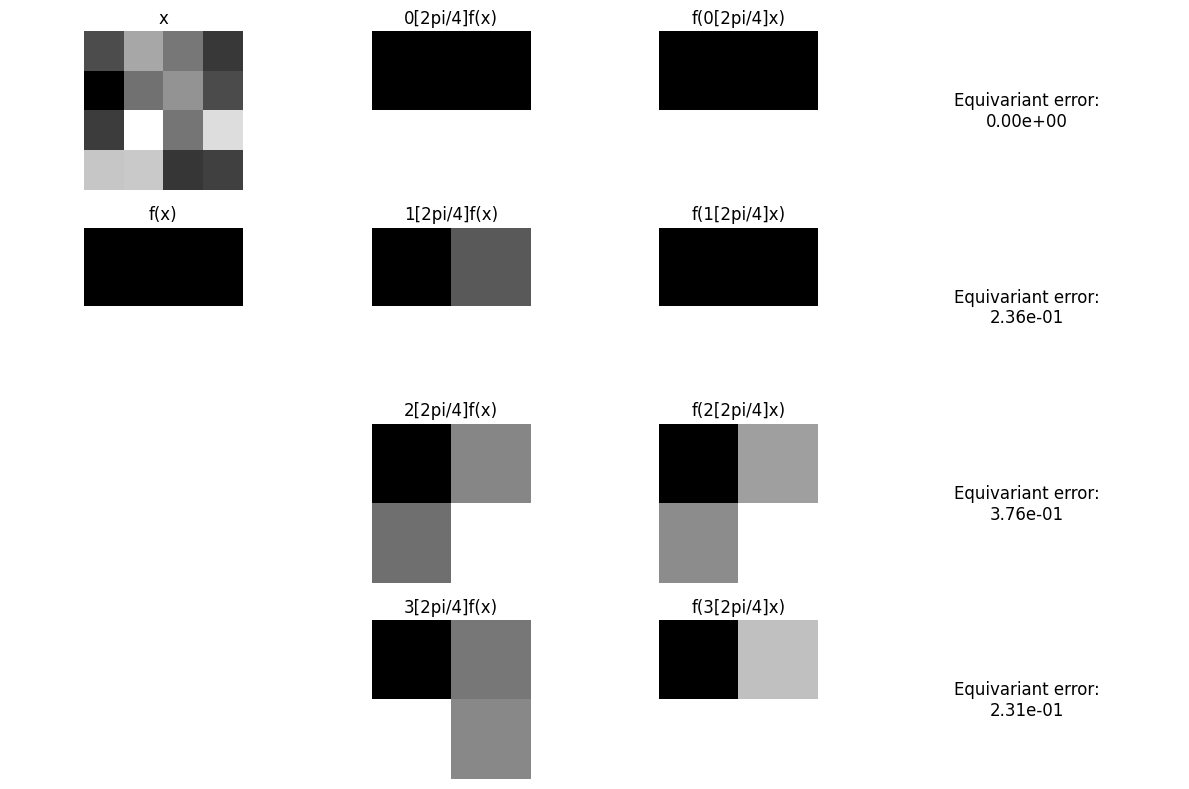

In [62]:
check_transformation2(model_eq.maxpool)

In [108]:
import matplotlib.patches as mpatches

def check_transformation3(self, x='random', size=4):
    device = get_module_device(self)

    c = self.in_type.size
    H = W = size  # or 10, like your example

    # create an empty image
    if x == 'line':
        img = torch.zeros(H, W, device=device)

        # draw a vertical line in the middle
        img[:, W // 2] = 1.0
        # img[:, 1] = 1.0

        # repeat this structured image for all c channels
        # final shape: (1, c, H, W)
        x_tensor = img.unsqueeze(0).repeat(c, 1, 1)      
        x_tensor = x_tensor.unsqueeze(0)
    elif x == 'random':
        torch.manual_seed(42) 
        x_tensor = torch.randn(1, c, H, W, device=device)
    x = GeometricTensor(x_tensor, self.in_type)

    fig, ax = plt.subplots(8, 4, figsize=(8, 8))

    # # plot x
    x_plot = x.tensor.detach().cpu().numpy()

    # apply layer
    group_elements = self.in_type.gspace.fibergroup.elements
    testing_elements = [g for g in group_elements if np.isclose(g.to('radians') % (np.pi/2), 0)]
    
    idx = [0, 2, 4, 6]
    for i, el in zip(idx, testing_elements):
        # Forward + transform
        out1 = self(x).transform(el).tensor.detach().cpu().numpy()
        out2 = self(x.transform(el)).tensor.detach().cpu().numpy()

        error = np.abs(out1 - out2).reshape(-1)

        # plot
        ax[i, 0].imshow(x_plot[0, 0], cmap='gray', vmin=0, vmax=1)
        ax[i, 0].set_title("x")

        g_x = x.transform(el).tensor.detach().cpu().numpy()
        ax[i, 1].imshow(g_x[0, 0], cmap='gray', vmin=0, vmax=1)
        ax[i, 1].set_title(f"{el}x")

        # arrow G
        
        ax[i+1, 0].axis('off')

        # f(x)
        f_x = self(x).tensor.detach().cpu().numpy()
        ax[i+1, 1].imshow(f_x[0, 0], cmap='gray', vmin=0, vmax=1)
        ax[i+1, 1].set_title("f(x)")

        ax[i+1, 2].imshow(out1[0, 0], cmap='gray', vmin=0, vmax=1)
        ax[i+1, 2].set_title(f"{el}f(x)")

        ax[i, 2].imshow(out2[0, 0], cmap='gray', vmin=0, vmax=1)
        ax[i, 2].set_title(f"f({el}x)")

        ax[i, 3].text(0.1, 0.0, f'Equivariant error:\n{error.mean():.2e}', ha='center', va='center', fontsize=12)

    for ax in ax.flatten():
        ax.axis('off')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    plt.tight_layout() 

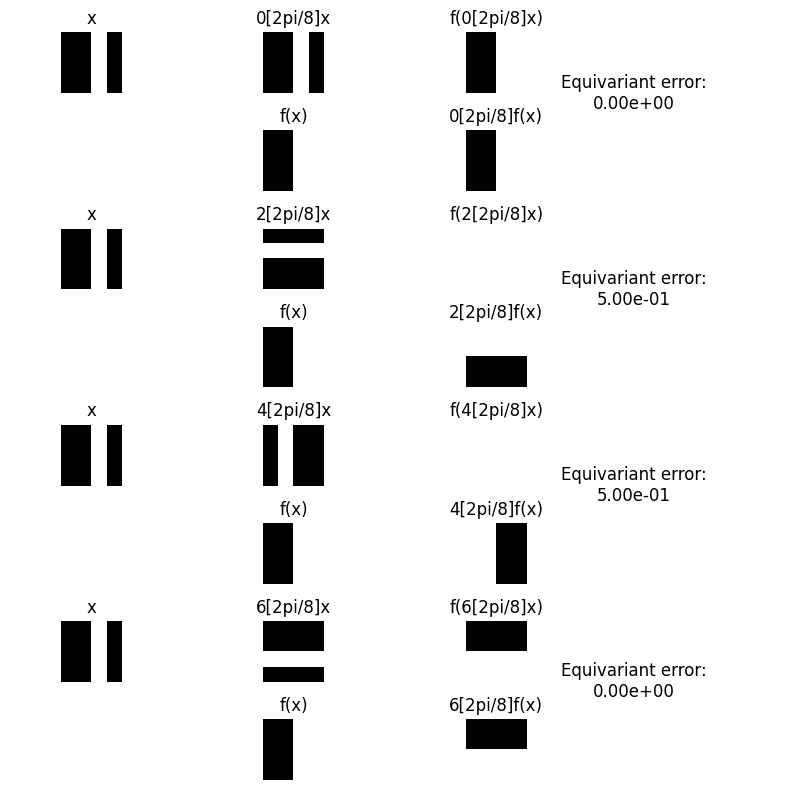

In [99]:
check_transformation3(model_eq_n8.maxpool, x='line')

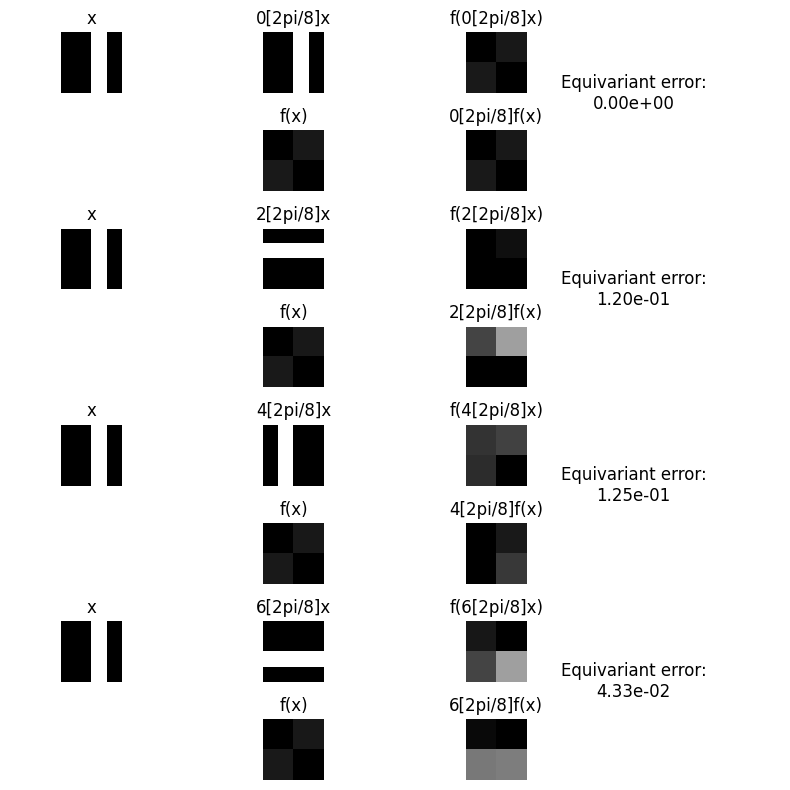

In [102]:
check_transformation3(model_eq_n8.conv1, x='line')

In [ ]:
from escnn import gspaces
from escnn import nn as enn

class Maxpooltest(nn.Module):
    def __init__(self, antialiased=False, sigma=0.33):
        super().__init__()
        self.r2_act = gspaces.rot2dOnR2(4)
        self.in_type = enn.FieldType(self.r2_act, [self.r2_act.regular_repr])

        if antialiased:
            self.maxpool = enn.PointwiseMaxPoolAntialiased2D(self.in_type, kernel_size=2, sigma=sigma, stride=2, padding=0)
        else:
            self.maxpool = enn.PointwiseMaxPool2D(self.in_type, kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        return self.maxpool(x)
    
model_max = Maxpooltest(antialiased=True).to(device)

TypeError: PointwiseMaxPoolAntialiased2D.__init__() missing 1 required positional argument: 'kernel_size'

In [132]:
class Avgtest(nn.Module):
    def __init__(self):
        super().__init__()
        self.r2_act = gspaces.rot2dOnR2(4)
        self.in_type = enn.FieldType(self.r2_act, [self.r2_act.regular_repr])

        self.pool = enn.PointwiseAvgPoolAntialiased2D(self.in_type, sigma=0.33, stride=2, padding=0)

    def forward(self, x):
        return self.pool(x)

model_avg = Avgtest().to(device)

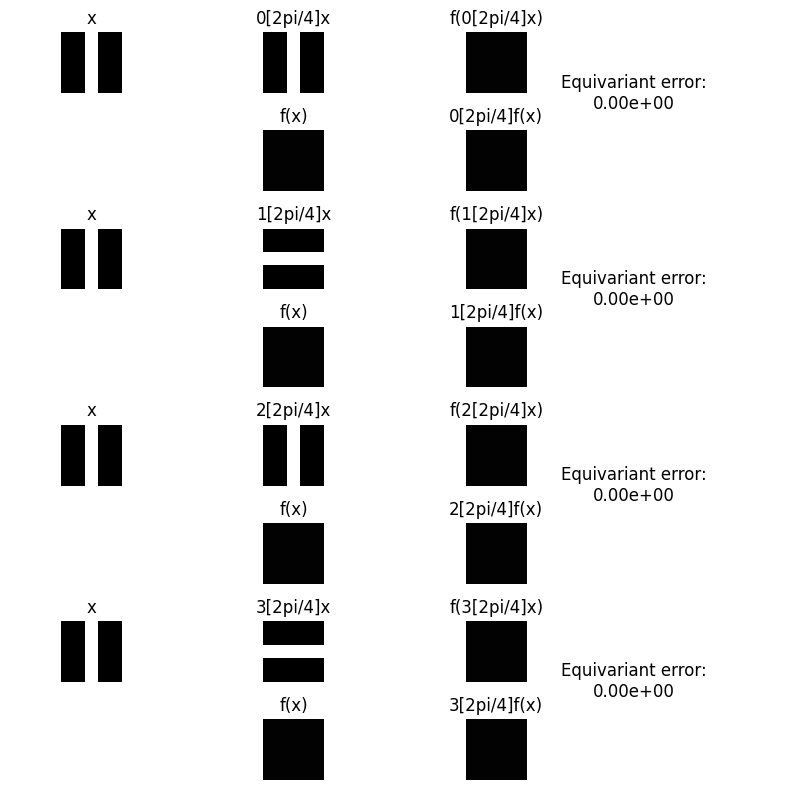

In [ ]:
check_transformation3(model_, x='line', size=5)

In [144]:
class CNNtest(nn.Module):
    def __init__(self, antialiased=True, sigma=0.33):
        super().__init__()
        self.r2_act = gspaces.rot2dOnR2(4)
        self.in_type = enn.FieldType(self.r2_act, [self.r2_act.regular_repr])
        self.out_type = enn.FieldType(self.r2_act, [self.r2_act.regular_repr])

        if antialiased:
            self.conv = enn.SequentialModule(enn.PointwiseAvgPoolAntialiased2D(self.in_type, sigma=sigma, stride=2, padding=1),
                enn.R2Conv(self.in_type, self.out_type, kernel_size=3, stride=1, padding=1, bias=False))
        else:
            self.conv = enn.R2Conv(self.in_type, self.out_type, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        return self.conv(x)
    
model_cnn = CNNtest(antialiased=False).to(device)

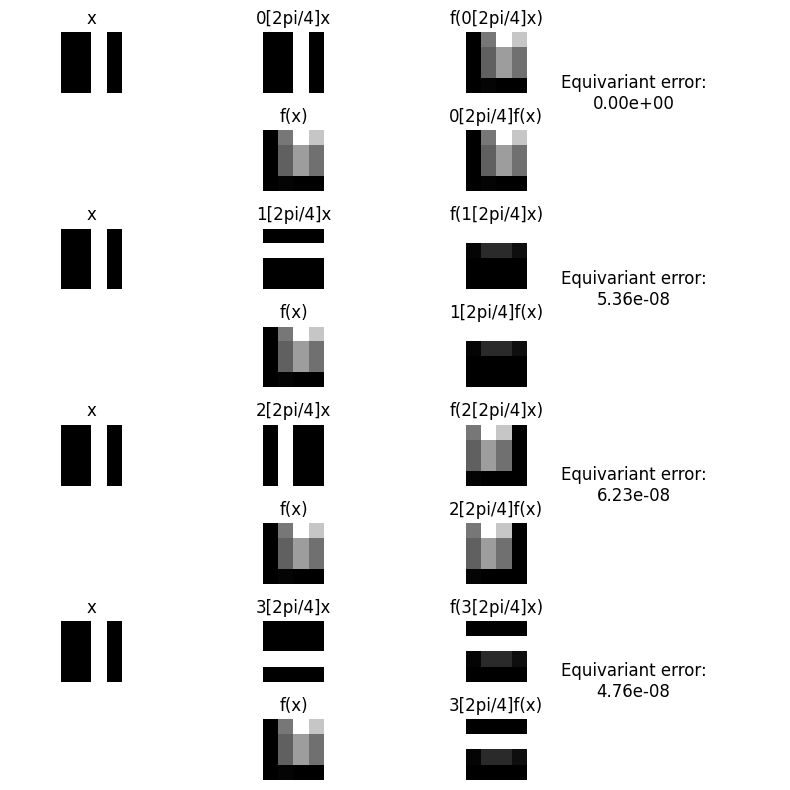

In [145]:
check_transformation3(model_cnn.conv, x='line')

In [81]:
model = Maxpooltest().to(device)
print(model)

Maxpooltest(
  (maxpool): PointwiseMaxPool2D()
)


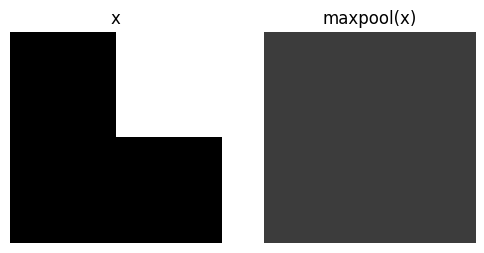

In [106]:
c = model_cnn.conv.in_type.size
H = W = 2  # or 10, like your example
# create an empty image

img = torch.zeros(H, W, device=device)
# draw a vertical line in the middle
# img[:, W // 2] = 1.0
img[0,1] = 1.0

x_tensor = img.unsqueeze(0).repeat(c, 1, 1)      
x_tensor = x_tensor.unsqueeze(0)

x = enn.GeometricTensor(x_tensor, model_cnn.conv.in_type)

fig, ax = plt.subplots(1, 2, figsize=(6, 6))

ax[0].imshow(x.tensor[0, 0].detach().cpu(), cmap='gray', vmin=0, vmax=1)

out = model_cnn.conv(x)
ax[1].imshow(out.tensor[0, 0].detach().cpu(), cmap='gray', vmin=0, vmax=1)

ax[0].set_title("x")
ax[1].set_title("maxpool(x)")

for ax in ax.flatten():
    ax.axis('off')

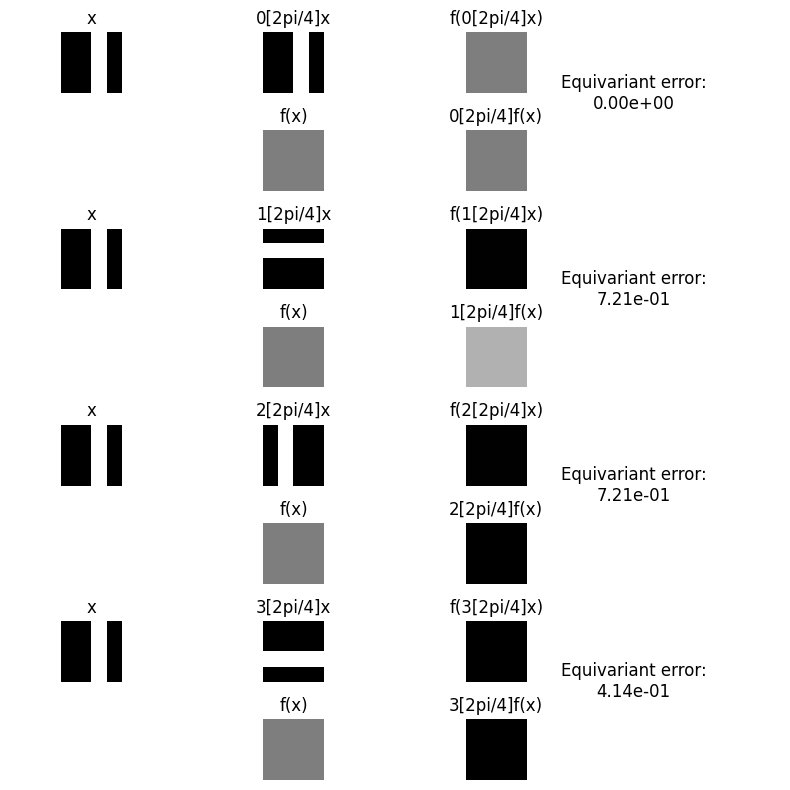

In [116]:
check_transformation3(model_cnn.conv, x='line')

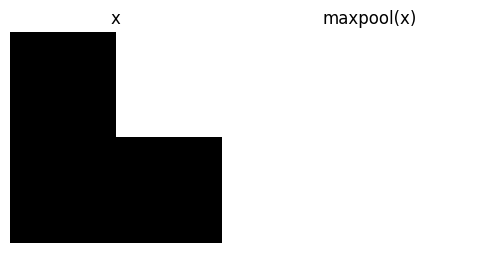

In [93]:
c = model.maxpool.in_type.size
H = W = 2  # or 10, like your example
# create an empty image

img = torch.zeros(H, W, device=device)
# draw a vertical line in the middle
# img[:, W // 2] = 1.0
img[0,1] = 1.0

x_tensor = img.unsqueeze(0).repeat(c, 1, 1)      
x_tensor = x_tensor.unsqueeze(0)

x = enn.GeometricTensor(x_tensor, model.maxpool.in_type)

fig, ax = plt.subplots(1, 2, figsize=(6, 6))

ax[0].imshow(x.tensor[0, 0].detach().cpu(), cmap='gray', vmin=0, vmax=1)

out = model.maxpool(x)
ax[1].imshow(out.tensor[0, 0].detach().cpu(), cmap='gray', vmin=0, vmax=1)

ax[0].set_title("x")
ax[1].set_title("maxpool(x)")

for ax in ax.flatten():
    ax.axis('off')

In [ ]:
c = model_eq_n8.maxpool.in_type.size

img = torch.zeros(2, 2, device=device)

img[:, 1] = 1.0

x_tensor = img.unsqueeze(0).repeat(c, 1, 1)      
x_tensor = x_tensor.unsqueeze(0)

x = GeometricTensor(x_tensor, model_eq_n8.maxpool.in_type)

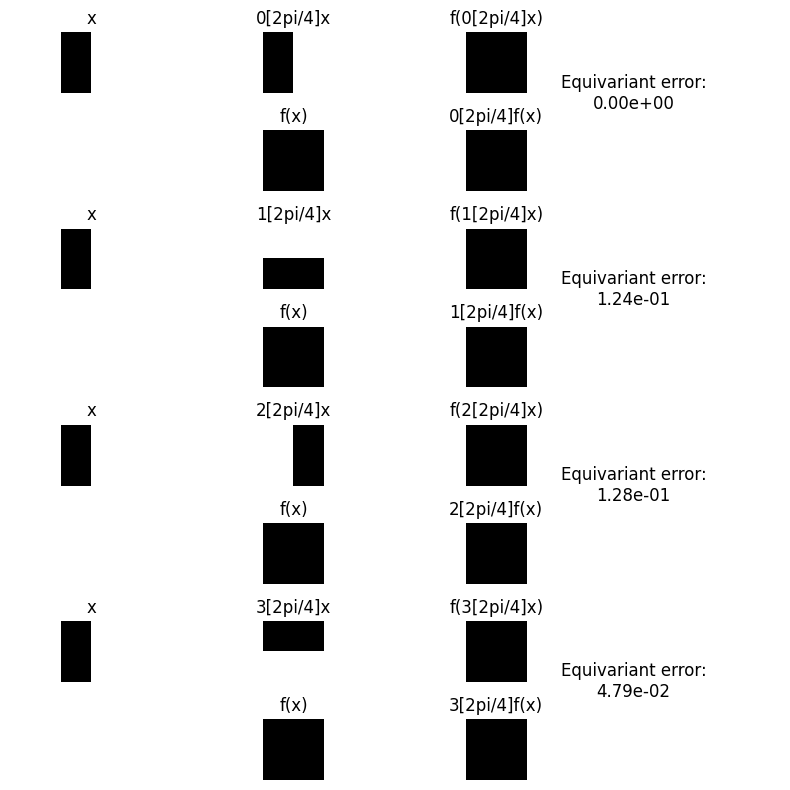

In [44]:
check_transformation3(model_eq.layer3[0].conv1, x='line')

In [34]:
for name, module in model_eq.named_modules():
    print(name)


conv1
conv1._basisexpansion
conv1._basisexpansion.block_expansion_('irrep_0', 'regular')
bn1
bn1.batch_norm_[4]
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.conv1._basisexpansion
layer1.0.conv1._basisexpansion.block_expansion_('regular', 'regular')
layer1.0.bn1
layer1.0.bn1.batch_norm_[4]
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.0.bn2.batch_norm_[4]
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.bn1.batch_norm_[4]
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer1.1.bn2.batch_norm_[4]
layer2
layer2.0
layer2.0.conv1
layer2.0.conv1._basisexpansion
layer2.0.bn1
layer2.0.bn1.batch_norm_[4]
layer2.0.relu
layer2.0.conv2
layer2.0.conv2._basisexpansion
layer2.0.bn2
layer2.0.bn2.batch_norm_[4]
layer2.0.downsample
layer2.0.downsample._basisexpansion
layer2.0.downsample._basisexpansion.block_expansion_('regular', 'regular')
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.bn1.batch_norm_[4]
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer2.1.bn2.batch_norm_[4]
layer3
layer3.0
layer3.0.c

# Dummy tests

In [22]:
from escnn import gspaces
from escnn import nn as enn

class Maxpooltest(nn.Module):
    def __init__(self, antialiased=False, sigma=0.33, stride=2, padding=0, kernel_size=2):
        super().__init__()
        self.r2_act = gspaces.rot2dOnR2(4)
        self.in_type = enn.FieldType(self.r2_act, [self.r2_act.regular_repr])

        if antialiased:
            self.maxpool = enn.PointwiseMaxPoolAntialiased2D(self.in_type, kernel_size=kernel_size, sigma=sigma, stride=stride, padding=padding)
        else:
            self.maxpool = enn.PointwiseMaxPool2D(self.in_type, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        return self.maxpool(x)
    
model_max = Maxpooltest().to(device)


In [ ]:
class Avgtest(nn.Module):
    def __init__(self, sigma=0.33, stride=2, padding=0):
        super().__init__()
        self.r2_act = gspaces.rot2dOnR2(4)
        self.in_type = enn.FieldType(self.r2_act, [self.r2_act.regular_repr])

        self.pool = enn.PointwiseAvgPoolAntialiased2D(self.in_type, sigma=sigma, stride=stride, padding=padding)

    def forward(self, x):
        return self.pool(x)


In [103]:
class CNNtest(nn.Module):
    def __init__(self, antialiased=False, sigma=0.33, stride=2, padding=0, kernel_size=3):
        super().__init__()
        self.r2_act = gspaces.rot2dOnR2(4)
        self.in_type = enn.FieldType(self.r2_act, [self.r2_act.regular_repr])
        self.out_type = enn.FieldType(self.r2_act, [self.r2_act.regular_repr])

        if antialiased:
            self.conv = enn.SequentialModule(enn.PointwiseAvgPoolAntialiased2D(self.in_type, sigma=sigma, stride=stride, padding=padding),
                enn.R2Conv(self.in_type, self.out_type, kernel_size=kernel_size, stride=1, padding=padding, bias=False))
        else:
            self.conv = enn.R2Conv(self.in_type, self.out_type, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

    def forward(self, x):
        return self.conv(x)
    
model_cnn = CNNtest(antialiased=False).to(device)

In [68]:
def check_transformation3_num(self, x='random', size=4):
    device = get_module_device(self)

    c = self.in_type.size
    H = W = size  # or 10, like your example

    # create an empty image
    if x == 'line':
        img = torch.zeros(H, W, device=device)

        # draw a vertical line in the middle
        img[:, W // 2] = 1.0
        # img[:, 1] = 1.0

        # repeat this structured image for all c channels
        # final shape: (1, c, H, W)
        x_tensor = img.unsqueeze(0).repeat(c, 1, 1)      
        x_tensor = x_tensor.unsqueeze(0)
    elif x == 'random':
        x_tensor = torch.randn(1, c, H, W, device=device)
    x = GeometricTensor(x_tensor, self.in_type)

    # apply layer
    group_elements = self.in_type.gspace.fibergroup.elements
    testing_elements = [g for g in group_elements if np.isclose(g.to('radians') % (np.pi/2), 0)]
    
    idx = [0, 2, 4, 6]
    errors = []
    for i, el in zip(idx, testing_elements):
        # Forward + transform
        out1 = self(x).transform(el).tensor.detach().cpu().numpy()
        out2 = self(x.transform(el)).tensor.detach().cpu().numpy()

        error = np.abs(out1 - out2).reshape(-1)

        g_x = x.transform(el).tensor.detach().cpu().numpy()

        # f(x)
        f_x = self(x).tensor.detach().cpu().numpy()
        errors.append(np.abs(out1 - out2).mean())
    
    mean_error = np.mean(np.array(errors))
    return mean_error

## Pooling

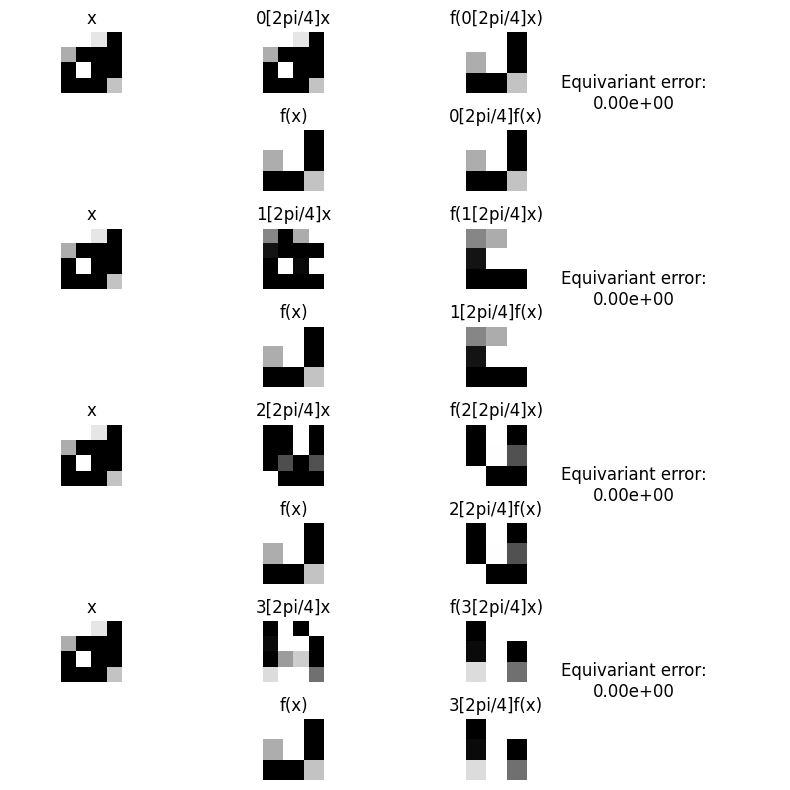

In [110]:
# default maxpool
model_max = Maxpooltest(kernel_size=2, padding=1).to(device)
check_transformation3(model_max.maxpool, x='random', size=4)

In [94]:
model_max = Maxpooltest(kernel_size=2, padding=0).to(device)
model_max_pad = Maxpooltest(kernel_size=2, padding=1).to(device)

for size in range(2, 10):
    test = (size - 2) % 2
    if test == 0:
        error = check_transformation3_num(model_max, size=size, x='random')
        print(f"Size: {size}, Equivariance error: {error} - Test index: {test}, using no padding")
    if test == 1:
        error = check_transformation3_num(model_max_pad, size=size, x='random')
        print(f"Size: {size}, Equivariance error: {error} - Test index: {test}, using padding")

Size: 2, Equivariance error: 0.0 - Test index: 0, using no padding
Size: 3, Equivariance error: 0.43397682905197144 - Test index: 1, using padding
Size: 4, Equivariance error: 0.0 - Test index: 0, using no padding
Size: 5, Equivariance error: 0.3567464351654053 - Test index: 1, using padding
Size: 6, Equivariance error: 0.0 - Test index: 0, using no padding
Size: 7, Equivariance error: 0.44642677903175354 - Test index: 1, using padding
Size: 8, Equivariance error: 0.0 - Test index: 0, using no padding
Size: 9, Equivariance error: 0.45143061876296997 - Test index: 1, using padding


In [ ]:
model_cnn = CNNtest().to(device)

for size in range(3, 15):
    test = (size - 3) % 2
    error = check_transformation3_num(model_cnn, size=size, x='random')
    print(f"Size: {size}, Equivariance error: {error} - Test index: {test}")

Size: 3, Equivariance error: 1.0244548320770264e-07 - Test index: 0, using no padding
Size: 4, Equivariance error: 1.3366799354553223 - Test index: 1, using no padding
Size: 5, Equivariance error: 8.207280188798904e-08 - Test index: 0, using no padding
Size: 6, Equivariance error: 0.9284509420394897 - Test index: 1, using no padding
Size: 7, Equivariance error: 9.905003395260792e-08 - Test index: 0, using no padding
Size: 8, Equivariance error: 0.8161158561706543 - Test index: 1, using no padding
Size: 9, Equivariance error: 9.398354450240731e-08 - Test index: 0, using no padding
Size: 10, Equivariance error: 0.7738595008850098 - Test index: 1, using no padding
Size: 11, Equivariance error: 1.0412186668418144e-07 - Test index: 0, using no padding
Size: 12, Equivariance error: 0.8214772939682007 - Test index: 1, using no padding
Size: 13, Equivariance error: 1.0337356570744305e-07 - Test index: 0, using no padding
Size: 14, Equivariance error: 0.854886531829834 - Test index: 1, using no

In [ ]:
(28 - )